## Assessing Resting Blood Pressure, Age, and Cholesterol Levels as Heart Disease Level Predictors in Cleveland and Hungary

### Aditya Nagrath

## Introduction

Heart disease is a broad term for multiple cardiovascular issues, such as irregular heartbeats, cholesterol-induced arterial blockage, and heart muscle issues (Mayo Clinic, 2024). Symptoms include chest tightness, dizziness, shortness of breath, and edema (bodily fluid buildup) (American Heart Association, 2024). Heart disease is a global issue, with widespread risk factors such as hypertension (high blood pressure) and increased age further heightening the disease prevalence (Canto et al., 2011). High Cholesterol levels are also a notable risk factor, as deposits within blood vessels can restrict blood flow to/from the heart. This can eventually lead to blood clots and cause strokes/heart attacks (Mayo Clinic, 2024).

For these reasons, I would like to explore whether these risk factors are good heart diseas  predictorsI would like to create a model fitted to the Cleveland dataset and perform predictions on both locations, to observe if predictive performance differsts. 

My Question: **Are Resting Blood Pressure, Age, and Cholesterol Levels Good Predictors of Heart Disease Level in American and/or Hungarian Patients?**


## Exploratory Data Analysis

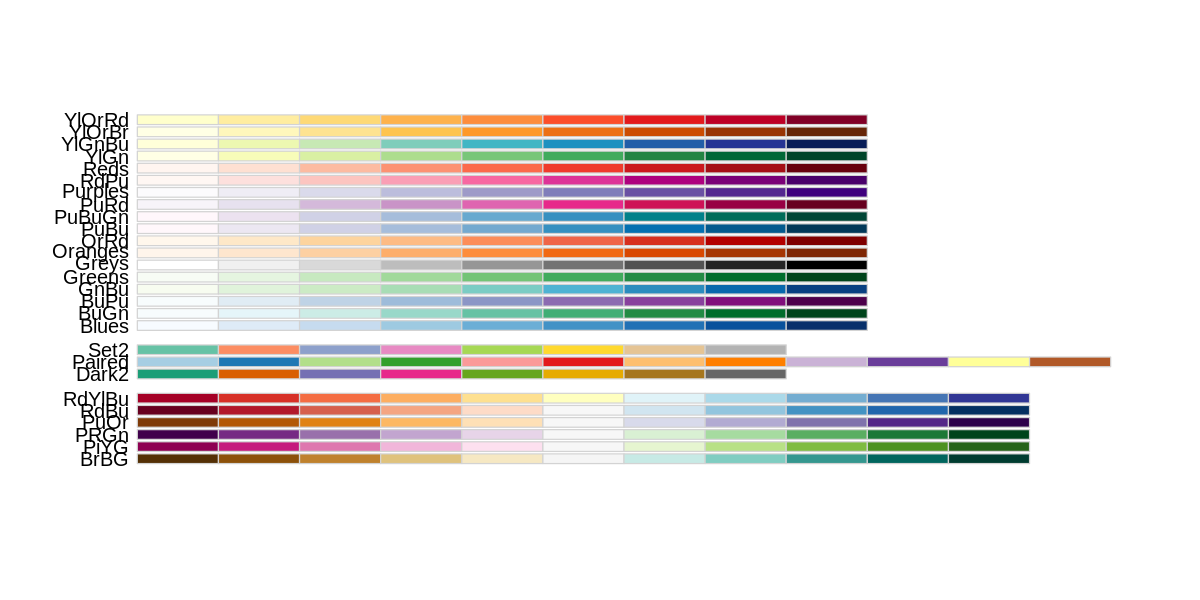

In [13]:
#Importing necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
display.brewer.all(colorblindFriendly=TRUE) #viewing colour blind friendly colour palette options for plots

In [24]:
#Importing and tidying Cleveland and Hungary Datasets
cleveland_data <- read_csv("heart_disease/processed.cleveland.data",col_names = 
                           c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", 
                             "oldpeak", "slope", "ca", "thal", "num")) |>                                      #importing data and adding column names
                   
                    mutate(sex = as_factor(sex),cp = as_factor(cp), fbs = as_factor(fbs),                      #changing categorical variables to factors
                               restecg = as_factor(restecg),exang = as_factor(exang), 
                           slope = as_factor(slope), thal = as_factor(thal), num = as_factor(num)) |>
                    mutate(ca = fct_recode(ca, "NA" = "?"))                                                    #replacing all "?" with NA's

hungary_data <- read_csv("heart_disease/processed.hungarian.data",col_names = 
                         c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>                    #importing data and adding column names

                mutate(sex = as_factor(sex),cp = as_factor(cp), fbs = as_factor(fbs),                          #changing categorical variables to factors
                   restecg = as_factor(restecg),exang = as_factor(exang), 
                       slope = as_factor(slope), thal = as_factor(thal), num = as_factor(num)) |>

                mutate(ca = fct_recode(ca, "NA" = "?"), chol = fct_recode(chol, "NA" = "?"),                   #replacing all "?" with NA's
                       slope = fct_recode(slope, "NA" = "?"), thal = fct_recode(thal, "NA" = "?"))|>
                mutate(chol = as.integer(chol), trestbps = as.integer(trestbps))                               #converting cholesterol & bp columns to integers
                

cleveland_data
hungary_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `trestbps = as.integer(trestbps)`.
Caused by warning:
! NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,0


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<chr>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
28,1,2,130,5,0,2,185,0,0,NA,NA,NA,0
29,1,2,120,70,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,1,0,0,170,0,0,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,136,1,0,150,1,3,2,NA,NA,1
58,0,2,180,144,0,0,110,1,1,2,NA,7,1
65,1,4,130,97,0,1,115,1,1,2,NA,NA,1


In [25]:
#Splitting into training and testing data
set.seed(1) 

cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num) 
cleveland_train <- training(cleveland_split) 
cleveland_test <- testing(cleveland_split)

hungary_split <- initial_split(hungary_data, prop = 0.75, strata = num) 
hungary_train <- training(hungary_split) 
hungary_test <- testing(hungary_split)

In [26]:
#Summarizing training data for each location to gather min, max, and average levels for cholesterol, blood pressure, and age for each level of heart disease

cleveland_avg <- cleveland_train |>
            group_by(num) |>
            summarize(number_of_patients = n(), avg_age = mean(age), min_age = min(age), max_age = max(age), 
                      avg_rbp = mean(trestbps), min_rbp = min(trestbps), max_rbp = max(trestbps), 
                      avg_chol = mean(chol), min_chol = min(chol), max_chol = max(chol))
cleveland_avg

hungary_avg <- hungary_train |>
            group_by(num) |>
            summarize(number_of_patients = n(), avg_age = mean(age), min_age = min(age), max_age = max(age), 
                      avg_rbp = mean(trestbps, na.rm=TRUE), min_rbp = min(trestbps, na.rm=TRUE), 
                      max_rbp = max(trestbps, na.rm=TRUE), avg_chol = mean(chol), 
                      min_chol = min(chol), max_chol = max(chol))
hungary_avg

num,number_of_patients,avg_age,min_age,max_age,avg_rbp,min_rbp,max_rbp,avg_chol,min_chol,max_chol
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,124,52.68548,29,76,129.7339,94,180,244.2903,126,564
1,41,55.68293,35,70,133.4878,108,192,248.7561,172,335
2,25,57.56000,42,69,133.9200,100,180,265.0000,169,409
3,26,55.15385,39,70,132.5769,100,180,241.7308,131,353
4,10,60.50000,38,77,139.0000,112,165,232.6000,166,304


num,number_of_patients,avg_age,min_age,max_age,avg_rbp,min_rbp,max_rbp,avg_chol,min_chol,max_chol
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>
0,141,46.74468,28,61,129.7286,100,190,63.85816,1,154
1,79,49.29114,31,66,134.5696,92,200,77.12658,1,152


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


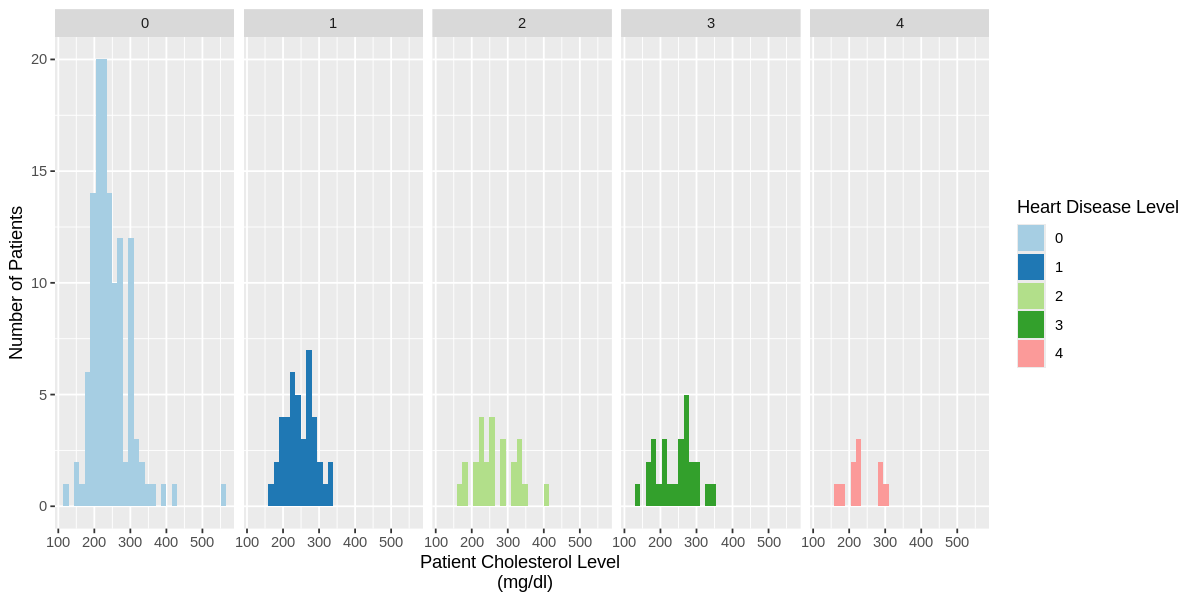

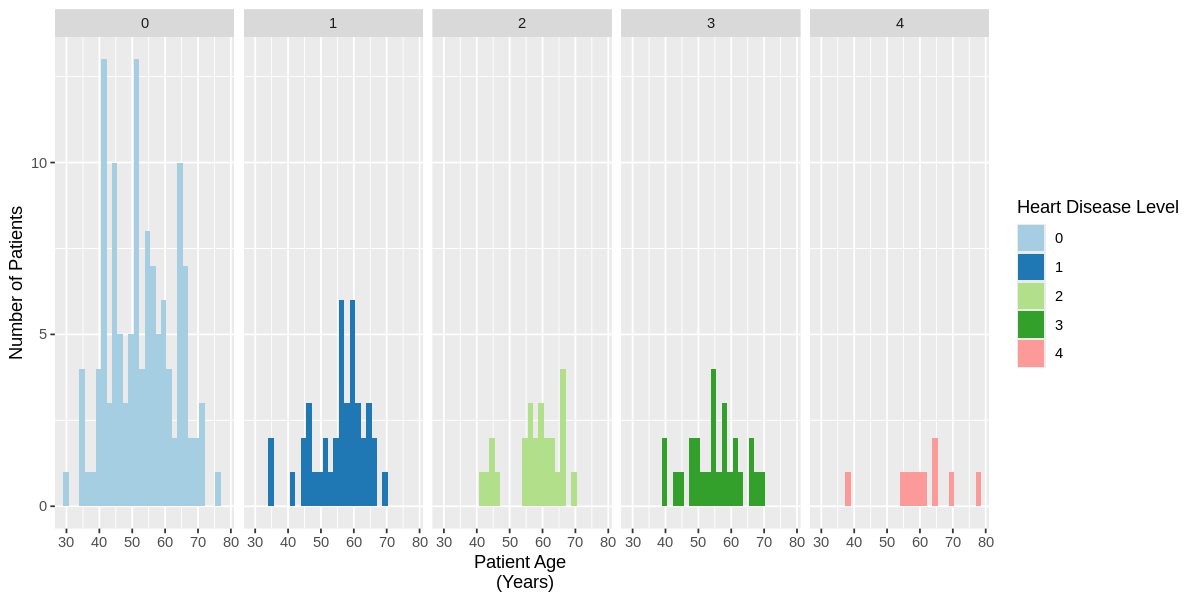

In [27]:
#Example visualizations using training data for Cleveland

options(repr.plot.height = 5, repr.plot.width = 10)                            #changing plot dimensions to fit screen
cleveland_chol_plot <- cleveland_train |>
ggplot(aes(x = chol, fill = num)) +                                                                            
geom_histogram() +
labs(x = "Patient Cholesterol Level \n (mg/dl)", y = "Number of Patients", fill = "Heart Disease Level") +
facet_grid(cols = vars(num)) +                                                #creating seperate plots based on Heart Disease Level
scale_fill_brewer(palette = "Paired")                                         #changing to colour blind friendly colour palette 
cleveland_chol_plot

cleveland_age_plot <- cleveland_train |>
ggplot(aes(x = age, fill = num)) +
geom_histogram() +
labs(x = "Patient Age \n (Years)", y = "Number of Patients", fill = "Heart Disease Level") +
facet_grid(cols = vars(num)) +                                                #creating seperate plots based on Heart Disease Level
scale_fill_brewer(palette = "Paired")                                         #changing to colour blind friendly colour palette 
cleveland_age_plot

## Methods
I will be analyzing a Heart Disease database from UC Irvine published in 1988. This contains data regarding heart disease patients from Cleveland, Hungary, Switzerland, and Long Beach, of which I will utilize the Cleveland and Hungary datasets. My variables of focus are; 
1) Age of the Patient
2) Cholesterol Level of the Patient(mg/dl)
3) Resting Blood Pressure of the Patient (mm/Hg)
4) Heart Disease Level of the Patient (0 = no disease, 1-4 = Different Levels of Heart Disease Severity)

I will design a KNN Model utilizing these variables to assess its predictive ability on Cleveland and Hungary testing data. Using assessing factors such as precision and recall, I plan to see if these variables are a viable heart disease predictor for patients at one or both of these locations. The model will be assessed using techniques such as cross-validation and tuning discussed in DSCI-100 Chapter 6 to select optimal K-values for each datI plan to fit the model to the Cleveland data, and then perform predictions on both cleveland and hungary data to observe potential performance differences, visualized in scatter plot format (with an inserted prediction line). 5). 


## Expected Outcomes and Significance

I expect heart disease levels >0 to be linked with higher age, cholesterol, and resting blood pressure in both locations. I also expect better predictions on the Cleveland data than Hungary since I'm fitting to the Cleveland data. These findings could help diagnose future patients, recognizing risky levels of the variables studied here, and also if prediction differs massively between the two locations, it can indicate to us that some other factor between the patients is causing the discrepency (since levels indicating heart disease in Cleveland may not indicate heart disease in Hungary or vice versa). 


## Bibliography

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

“Heart Failure Signs and Symptoms.” www.heart.org, 7 June 2024, www.heart.org/en/health-topics/heart-failure/warning-signs-of-heart-failure.

Canto, John G., Kiefe, Catarina I., Rogers, William J. (2011). “Number of Coronary Heart Disease Risk Factors and Mortality in Patients With First Myocardial Infarction.” JAMA, vol. 306, no. 19, Nov. 2011, https://doi.org/10.1001/jama.2011.1654.

“Heart Disease - Symptoms and Causes - Mayo Clinic.” Mayo Clinic, 25 Aug. 2022, www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118.